In [ ]:
from webdav3.client import Client
from dotenv import load_dotenv
load_dotenv()
import os
import pandas as pd
import xml.etree.ElementTree as ET
import regex as re
from tqdm import tqdm
import json

DB_HOST = os.getenv("DB_HOST")
NC_ACC = os.getenv("NC_ACC")
NC_PASS = os.getenv("NC_PASS")

In [136]:
def webdav_login(server_url, username, password):
    try:
        # connect 2 webdav server
        client = Client({
            'webdav_hostname': server_url,
            'webdav_login': username,
            'webdav_password': password
        })

       #check connection
        if client.check():
            return client
        else:
            print("Wrong login data.")
            return None
    except Exception as e:
        print(f"Exception: {e}")
        return None


In [ ]:
def get_meta(client, path, server_url):
    url=f"{server_url}{path}"
    # PROPFIND Anfrage senden
    response = client.session.request(
        method="PROPFIND",
        url=url,
        headers={'Depth': '1'},
        data="""<?xml version="1.0" encoding="utf-8"?>
    <d:propfind xmlns:d="DAV:" xmlns:oc="http://owncloud.org/ns">
        <d:prop>
            <oc:id/>
            <oc:fileid/>
            <oc:tags/>
            <d:getcontenttype/>
        </d:prop>
    </d:propfind>"""
    )

    # Parse XML response
    root = ET.fromstring(response.text)
    ns = {'oc': 'http://owncloud.org/ns'}
    fileid = root.find('.//oc:fileid', ns).text if root.find('.//oc:fileid', ns) is not None else None
    id = root.find('.//oc:id', ns).text if root.find('.//oc:id', ns) is not None else None
    tags = root.find('.//oc:tags', ns).text if root.find('.//oc:tags', ns) is not None else None
    mime = root.find('.//d:getcontenttype').text if root.find('.//d:getcontenttype') is not None else None

    return id, fileid, tags, mime

In [49]:
def folder_to_dict(path, client):
    entries = client.list(path)[1:]  # skip the listing of the directory itself
    children = {}
    for entry in entries:
        full_entry_path = path + entry
        if entry.endswith("/"):
            # recurse into subfolder
            children[entry] = folder_to_dict(full_entry_path, client)
        else:
            # file
            children[entry] = entry
    return children

In [ ]:
def folder_to_dict_w_meta_tqdm(path, client, server_url):
    entries = client.list(path)[1:]  # skip the listing of the directory itself
    children = {}
    for entry in tqdm(entries):
        full_entry_path = path + entry
        if entry.endswith("/"):
            # recurse into subfolder
            children[entry] = folder_to_dict_w_meta(full_entry_path, client, server_url)
        else:
            # file: call file_id and store the response
            id, fileid, tags, mime = get_meta(client, full_entry_path, server_url)
            children[entry] = {"name": entry, "id": id, "fileid": fileid, "tags": tags, "path": full_entry_path, "mime": mime}
    return children


def folder_to_dict_w_meta(path, client, server_url):
    entries = client.list(path)[1:]  # skip the listing of the directory itself
    children = {}
    for entry in entries:
        full_entry_path = path + entry
        if entry.endswith("/"):
            # recurse into subfolder
            children[entry] = folder_to_dict_w_meta(full_entry_path, client, server_url)
        else:
            # file: call file_id and store the response
            id, fileid, tags, mime = get_meta(client, full_entry_path, server_url)
            children[entry] = {"name": entry, "id": id, "fileid": fileid, "tags": tags, "path": full_entry_path, "mime": mime}
    return children

In [ ]:

server_url = f'''http://{DB_HOST}:8080/remote.php/dav/files/{NC_ACC}'''
username = NC_ACC
password = NC_PASS
path =  "/Bre/Artwork/"
#path = "/Bre/"

client = webdav_login(server_url, username, password)

if client:
    print("client connected")
    root_dict = {path.strip("/").split("/")[-1]: folder_to_dict_w_meta_tqdm(path, client, server_url)}
    open("webdav_meta.json", "w").write(json.dumps(root_dict, indent=4))


    

client connected


100%|██████████| 9/9 [06:14<00:00, 41.56s/it]


In [308]:
def get_meta_fromdict(data):
    if len(data) == 1:
        first_val = next(iter(data.values()))
        content = first_val
    else:
        content = data

    for key, val in content.items():
        # if it's a folder entry (string that ends with "/") and val is mapping-like, recurse
        if key.endswith("/"):
            get_meta_fromdict(val)
        else:
            # val should be a metadata mapping for a file; iterate if possible
            if getattr(val, "items", None):
                for subkey, subval in val.items():
                    if subkey in ("fileid", "name", "path"):
                        print('      ', subkey, subval)
            else:
                # unexpected structure: just print the value
                print('unexpected structure:      ', val)

In [327]:
def get_meta_fromdict(data):
    if len(data) == 1:
        first_val = next(iter(data.values()))
        content = first_val
    else:
        content = data

    for key, val in content.items():
        # if it's a folder entry (string that ends with "/") and val is mapping-like, recurse
        if key.endswith("/"):
            get_meta_fromdict(val)
        else:
            if getattr(val, "items", None):
                for subkey, subval in val.items():
                    if subkey in ("fileid", "name", "path"):
                        print('      ', subkey, subval)
                        return subkey, subval
            else:
                # unexpected structure: just print the value
                print('      ', key, val)
                return key, val



In [324]:
get_meta_fromdict(root_dict)

       name 1265.jpg
       fileid 19515
       path /Bre/Artwork/AI_art/bearbeitet/1265.jpg
       name 1749.jpg
       fileid 19516
       path /Bre/Artwork/AI_art/bearbeitet/1749.jpg
       name 1962-bottocelli-room.jpg
       fileid 19517
       path /Bre/Artwork/AI_art/bearbeitet/1962-bottocelli-room.jpg
       name 295.jpg
       fileid 19514
       path /Bre/Artwork/AI_art/bearbeitet/295.jpg
       name Botti_ai Kopie.jpg
       fileid 19548
       path /Bre/Artwork/AI_art/bearbeitet/Botti_ai Kopie.jpg
       name bottitapete.jpg
       fileid 19557
       path /Bre/Artwork/AI_art/bearbeitet/bottitapete.jpg
       name bottitapete kleiner.jpg
       fileid 19549
       path /Bre/Artwork/AI_art/bearbeitet/bottitapete kleiner.jpg
       name bottitapete kleiner Kopie.jpg
       fileid 19551
       path /Bre/Artwork/AI_art/bearbeitet/bottitapete kleiner Kopie.jpg
       name bottitapete_quer.jpg
       fileid 19552
       path /Bre/Artwork/AI_art/bearbeitet/bottitapete_quer.jpg
   

In [330]:
dict1 = root_dict['Artwork']['AI_art/']['bearbeitet/']["1265.jpg"]
len(dict1)
dict1['path']

'/Bre/Artwork/AI_art/bearbeitet/1265.jpg'

Image size: 0.25 MB


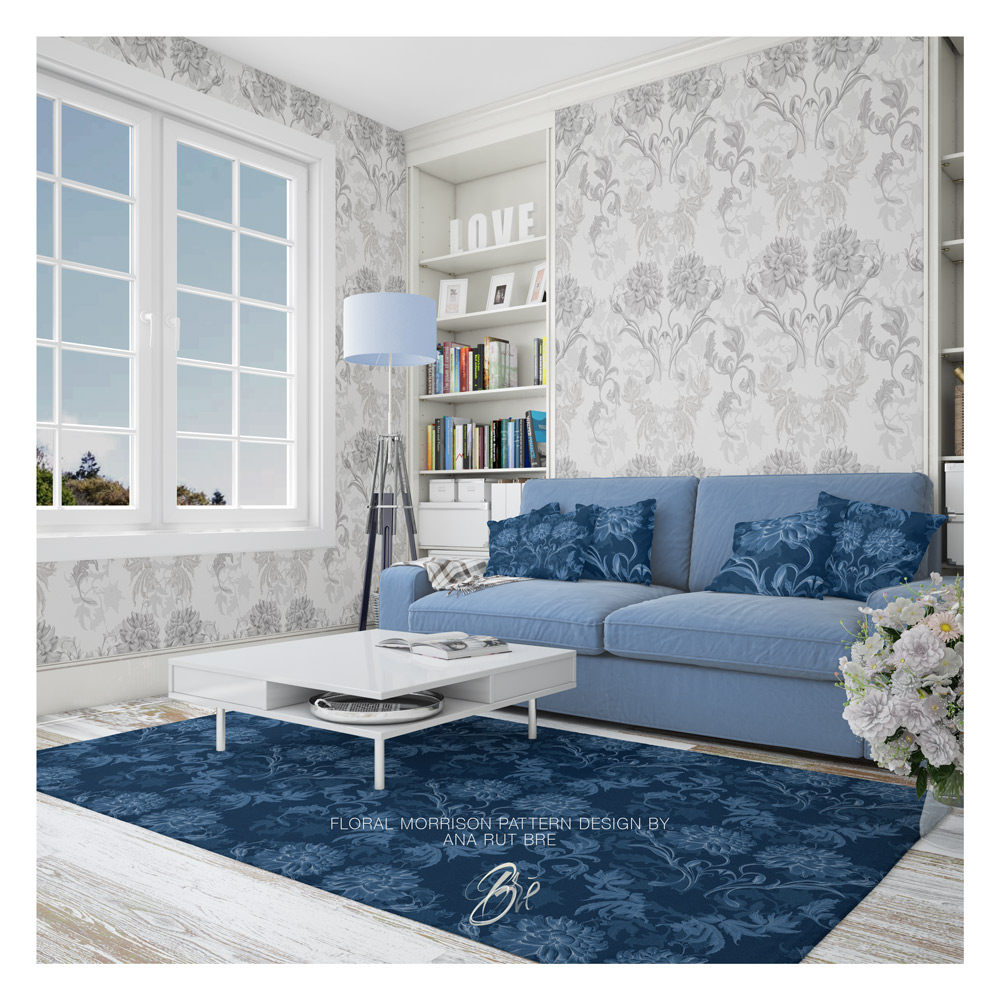

In [ ]:
import requests
from requests.auth import HTTPBasicAuth
from io import BytesIO
from IPython.display import display, Image
from PIL import Image as PILImage

server_url = f'''http://{DB_HOST}:8080/remote.php/dav/files/{NC_ACC}'''
username = NC_ACC
password = NC_PASS
# Replace these variables with your details
file_path = dict1['path']  # Remote file path

# Construct the full URL
file_url = f"{server_url}{file_path}"

# Send a GET request to download the file
response = requests.get(file_url, auth=HTTPBasicAuth(username, password), stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Save the file content in memory using BytesIO
    file_in_memory = BytesIO()
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file_in_memory.write(chunk)
    file_in_memory.seek(0)  # Move the pointer to the start of the BytesIO object
    size_in_bytes = len(file_in_memory.getvalue())
    size_in_mb = size_in_bytes / (1024 * 1024)  # Convert bytes to megabytes
    print(f"Image size: {size_in_mb:.2f} MB")

       # Open the image using Pillow (PIL)
    img = PILImage.open(file_in_memory)

else:
    print(f"Failed to download file. Status code: {response.status_code}")
    print(response.text)


In [334]:
import mlx.core as mx
from mlx_vlm import load, generate
from mlx_vlm.prompt_utils import apply_chat_template
from mlx_vlm.utils import load_config
from PIL import Image as Im
from IPython import display
from IPython.display import display
from tqdm import tqdm
from dotenv import load_dotenv
import os
import regex as re
from time import sleep
import time

# Load the model
model_path = "mlx-community/pixtral-12b-bf16"
model, processor = load(model_path)
config = load_config(model_path)

/Users/tom/Fine-arts-ML/Fine-Arts-Main/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 236043.08it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 147766.81it/s]


Floral, Morrison Pattern, Living Room, Blue Sofa, Area Rug, Home Decor, Interior Design, Wallpaper, Coffee Table, Bookshelf, Lamp, Floral Pillows, Blue Accent, White Walls, Wood Floor, Love Sign, Books, Flowers, Cozy, Modern Classic, Design by Ana Put Bre


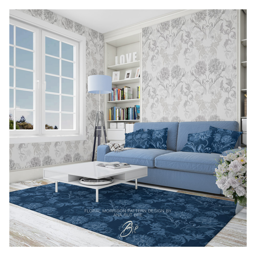

Time taken for iteration : 53.14 seconds
Generator token count: 68  Generator tokens per second: 2.003865461427842
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
Average time taken: 53.14 seconds


In [ ]:
avg_time = []
start_time = time.time()
image = img
image_smol = image.resize((256, 256))
prompt = "Generate Tags for the image, as if you were a curator and wanted to sell the image in online shops. Only return the tags, no other text."
formatted_prompt = apply_chat_template(processor, config, prompt, num_images=1)
output = generate(model, processor, formatted_prompt, image, verbose=False)
endtime = time.time()
display(image_smol)
this_run_time = endtime - start_time
avg_time.append(this_run_time)
print(f"Time taken for iteration : {this_run_time:.2f} seconds")
print( 'Generator token count:', output.generation_tokens , ' Generator tokens per second:', output.generation_tps)
print( ' - ' * 50)

print(f"Average time taken: {sum(avg_time) / len(avg_time):.2f} seconds")